# Data Synthesis from the Hannum data

## 1. Data loading

 Let's set the notebook in autoreload mode and load the required libraries 

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from biolearn.data_library import DataLibrary
import pandas as pd
from sdv.metadata import Metadata


First we load the data

In [14]:
hannum_acc = 'GSE40279'
if 'hannum' not in locals():
    # Load the dataset
    # This will download the dataset if it is not already available
    # The dataset is from the GEO database, specifically GSE40279
    hannum = DataLibrary().get(hannum_acc).load()
print(f'{hannum.dnam=}')
print(f'{hannum.metadata=}')

hannum.dnam=                GSM989827  GSM989828  GSM989829  GSM989830  GSM989831  \
id                                                                      
cg00000029       0.464197   0.454883   0.485764   0.480785   0.501220   
cg00000108       0.941091   0.939033   0.918802   0.929908   0.934548   
cg00000109       0.911182   0.596455   0.870333   0.889689   0.890450   
cg00000165       0.132014   0.206917   0.162861   0.197780   0.148437   
cg00000236       0.717861   0.723935   0.719196   0.704061   0.754913   
...                   ...        ...        ...        ...        ...   
ch.9.98937537R   0.042808   0.036811   0.042844   0.042258   0.039613   
ch.9.98957343R   0.052589   0.053343   0.045973   0.048733   0.039254   
ch.9.98959675F   0.035624   0.075618   0.126421   0.084051   0.165874   
ch.9.98989607R   0.028066   0.017428   0.021752   0.027504   0.020889   
ch.9.991104F     0.043850   0.032950   0.022375   0.053007   0.000000   

                GSM989832  GSM989833  

Now let's make a biolearn function to do load an accession, choose a target, and wrap it together in a dataframe, so that we can augment it with SDV

In [19]:
def get_biolearn_df(accession: str, target_col: str | None = None, stop_cols : int | None = 0) -> tuple[pd.DataFrame, Metadata]:
    """
    Returns the Biolearn Dataset for the specified accession, including all the methylation data and the selected target column.
    """
    data = DataLibrary().get(accession).load()
    if target_col is not None and target_col not in data.metadata.columns:
        raise ValueError(f"Target column '{target_col}' not found in metadata."
                         f" Available columns: {data.metadata.columns.tolist()}")
    dnam = data.dnam.T.iloc[:, :stop_cols]
    df = (dnam.join(data.metadata[target_col]) if target_col else 
          dnam)

    return (
        df,
        Metadata.detect_from_dataframe(
            data=df,
            table_name=accession))

stop_cols = int(1e3)
hannum_data, hannum_metadata = get_biolearn_df(hannum_acc, 
                                               target_col='age',
                                               stop_cols=stop_cols)

print(f'{hannum_data.shape=}')
display(hannum_data.head())

hannum_data.shape=(656, 1001)


,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,cg00040945,cg00040986,cg00041014,cg00041047,cg00041084,cg00041270,cg00041311,cg00041328,cg00041368,age
GSM989827,0.464197,0.941091,0.911182,0.132014,0.717861,0.686521,0.805003,0.228244,0.338483,0.016508,...,0.011160,0.876203,0.853565,0.961522,0.068017,0.675600,0.888616,0.021784,0.913497,67.0
GSM989828,0.454883,0.939033,0.596455,0.206917,0.723935,0.619084,0.814672,0.310879,0.418998,0.005747,...,0.006298,0.861849,0.839798,0.960310,0.086748,0.653151,0.908870,0.028540,0.903532,89.0
GSM989829,0.485764,0.918802,0.870333,0.162861,0.719196,0.635678,0.824336,0.263215,0.424736,0.012197,...,0.003847,0.842399,0.823604,0.969940,0.078936,0.637450,0.943050,0.025848,0.916483,66.0
GSM989830,0.480785,0.929908,0.889689,0.197780,0.704061,0.610864,0.811152,0.316761,0.398772,0.019945,...,0.011580,0.854247,0.824178,0.947424,0.065263,0.665156,0.888661,0.033617,0.898217,64.0
GSM989831,0.501220,0.934548,0.890450,0.148437,0.754913,0.651262,0.808628,0.338289,0.366965,0.000000,...,0.002676,0.864759,0.842210,0.918176,0.094727,0.652984,0.904064,0.032851,0.902618,62.0


Now we can just synthesise more data!

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [20]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(hannum_metadata)
synthesizer.fit(hannum_data)

C:\Users\ferdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sdv\single_table\base.py:123: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



Now the synthesizer is ready to use!

## 2.2 Generating Synthetic Data

Use the `sample` function and pass in any number of rows to synthesize.

In [23]:
synthetic_data = synthesizer.sample(num_rows=5e3)
synthetic_data.head()

,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,cg00040945,cg00040986,cg00041014,cg00041047,cg00041084,cg00041270,cg00041311,cg00041328,cg00041368,age
0,0.400277,0.940740,0.880711,0.253905,0.707013,0.611270,0.862394,0.276539,0.422574,0.017728,...,0.009172,0.856009,0.845781,0.983334,0.050634,0.645732,0.890175,0.026532,0.903903,52.0
1,0.541694,0.938511,0.891542,0.109947,0.719618,0.637922,0.829832,0.354762,0.357362,0.021757,...,0.011482,0.867800,0.833960,0.943272,0.064204,0.666665,0.923176,0.018725,0.892192,64.0
2,0.427134,0.924017,0.953008,0.245483,0.730184,0.611707,0.867683,0.291825,0.495808,0.005798,...,0.006658,0.819597,0.804690,0.954053,0.045942,0.676564,0.934820,0.018173,0.926497,86.0
3,0.435070,0.939886,0.872420,0.234438,0.741659,0.557209,0.804438,0.346762,0.417022,0.007060,...,0.006882,0.817093,0.815667,0.832409,0.042045,0.594844,0.906972,0.035363,0.906550,63.0
4,0.426977,0.952096,0.961816,0.135264,0.744599,0.762506,0.789962,0.366011,0.447250,0.010626,...,0.012033,0.883438,0.815620,0.926979,0.054960,0.650963,0.921499,0.021002,0.920975,40.0


The synthesizer is generating synthetic guests in the **same format as the original data**.

## 2.3 Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [24]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=hannum_data,
    synthetic_data=synthetic_data,
    metadata=hannum_metadata,
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 1001/1001 [00:00<00:00, 3903.87it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 110.97it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [25]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    hannum_data,
    synthetic_data,
    hannum_metadata,
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 1001/1001 [00:03<00:00, 253.26it/s]|
Column Shapes Score: 85.18%

(2/2) Evaluating Column Pair Trends: |██████████| 500500/500500 [31:50<00:00, 262.03it/s]| 
Column Pair Trends Score: 98.88%

Overall Score (Average): 92.03%



According to the score, the synthetic data is about 88% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 89%. Which columns had the highest vs. the lowest scores?

In [26]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,cg00000029,KSComplement,0.962800
1,cg00000108,KSComplement,0.944788
2,cg00000109,KSComplement,0.946995
3,cg00000165,KSComplement,0.907763
4,cg00000236,KSComplement,0.955483
...,...,...,...
996,cg00041270,KSComplement,0.964620
997,cg00041311,KSComplement,0.938561
998,cg00041328,KSComplement,0.971785
999,cg00041368,KSComplement,0.952946


## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [ ]:
from sdv.evaluation.single_table import get_column_plot
from IPython.display import Image
from IPython.display import display

#TODO: this won't work as of now - something is wrong with pyplot.
fig = get_column_plot(
    real_data=hannum_data,
    synthetic_data=synthetic_data,
    column_name='age',
    metadata=hannum_metadata
)

use_pyplot = False
if use_pyplot:
    fig.show()
else:
    # TODO: uncomment the following line to see the image, once everything runs
    #fig.write_image('img/picture.png')
    #display(fig)
    pass

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [38]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=hannum_data,
    synthetic_data=synthetic_data,
    column_names=['cg00000108','cg00000029'],
    metadata=hannum_metadata
)

fig.show()

## 2.5 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [39]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = GaussianCopulaSynthesizer.load('my_synthesizer.pkl')

# 3. Gaussian Copula Customization

A key benefit of using the Gaussian Copula is **customization and transparency**. This synthesizer estimates the shape of every column using a 1D distribution. We can set these shapes ourselves.

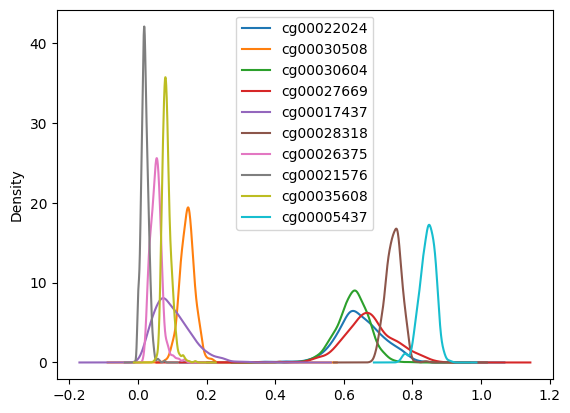

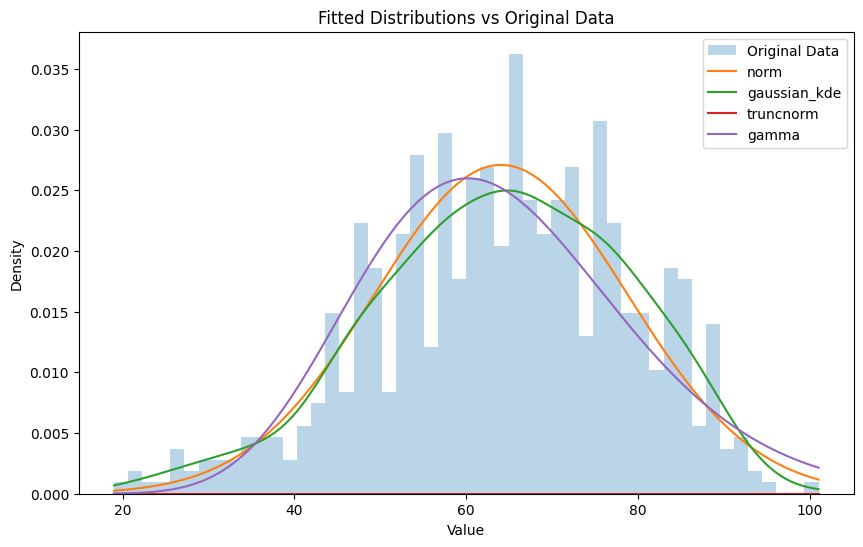

norm: MSE = 0.000380
gaussian_kde: MSE = 0.000378
truncnorm: MSE = 0.000609
gamma: MSE = 0.000385


In [58]:
import numpy as np
from scipy.stats import norm, truncnorm, beta, gamma, gaussian_kde
from sklearn.metrics import mean_squared_error

hannum_data.iloc[:,:-1].sample(10,random_state=42, axis=1).plot.kde()
import matplotlib.pyplot as plt

data = hannum_data.iloc[:, -1].dropna().values
x = np.linspace(data.min(), data.max(), 200)

fits = {}
mse = {}

# Fit norm
params_norm = norm.fit(data)
pdf_norm = norm.pdf(x, *params_norm)
mse['norm'] = mean_squared_error(np.histogram(data, bins=200, density=True)[0], norm.pdf(np.histogram(data, bins=200)[1][:-1], *params_norm))
fits['norm'] = pdf_norm

# Fit gaussian_kde
kde = gaussian_kde(data)
pdf_kde = kde(x)
mse['gaussian_kde'] = mean_squared_error(np.histogram(data, bins=200, density=True)[0], kde(np.histogram(data, bins=200)[1][:-1]))
fits['gaussian_kde'] = pdf_kde

# Fit truncnorm
a, b = (data.min() - data.mean()) / data.std(), (data.max() - data.mean()) / data.std()
params_truncnorm = truncnorm.fit(data, floc=data.min(), fscale=data.std())
pdf_truncnorm = truncnorm.pdf(x, *params_truncnorm)
mse['truncnorm'] = mean_squared_error(np.histogram(data, bins=200, density=True)[0], truncnorm.pdf(np.histogram(data, bins=200)[1][:-1], *params_truncnorm))
fits['truncnorm'] = pdf_truncnorm

# Fit gamma
params_gamma = gamma.fit(data, floc=0)
pdf_gamma = gamma.pdf(x, *params_gamma)
mse['gamma'] = mean_squared_error(np.histogram(data, bins=200, density=True)[0], gamma.pdf(np.histogram(data, bins=200)[1][:-1], *params_gamma))
fits['gamma'] = pdf_gamma

# Plot
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, density=True, alpha=0.3, label='Original Data')
for dist_name, pdf in fits.items():
    plt.plot(x, pdf, label=dist_name)
plt.legend()
plt.title('Fitted Distributions vs Original Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Print MSEs
for dist_name, error in mse.items():
    print(f"{dist_name}: MSE = {error:.6f}")

They all kind of look like gaussians, although slightly skewed.

Let's see which one is better...

In [60]:
import datetime
custom_synthesizer = {}
for kind in ['norm', 'beta', 'truncnorm', 'gamma', 'gaussian_kde']:
    print(datetime.datetime.now(), 
          f': Creating custom synthesizer for {kind}...', )
    custom_synthesizer[kind] = GaussianCopulaSynthesizer(
        hannum_metadata,
        default_distribution=kind,
        numerical_distributions={
            'age': 'gaussian_kde'
        }
    )

    custom_synthesizer[kind].fit(hannum_data)

2025-05-31 17:23:21.786834 : Creating custom synthesizer for norm...
2025-05-31 17:23:35.354666 : Creating custom synthesizer for beta...
2025-05-31 17:24:40.329419 : Creating custom synthesizer for truncnorm...
2025-05-31 17:24:56.833421 : Creating custom synthesizer for gamma...
2025-05-31 17:25:41.131611 : Creating custom synthesizer for gaussian_kde...


After training, we can inspect the distributions. In this case, the synthesizer returns the parameter it learned using the truncnorm distribution.

<font color=navy><i>More information about truncnorm distribution is available in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html).</i></font>

In [61]:
learned_distributions = {}
for kind, synthesizer in custom_synthesizer.items():
    print(datetime.datetime.now(), 
          f': Getting learned distributions for {kind}...')
    learned_distributions[kind] = synthesizer.get_learned_distributions()

2025-05-31 17:38:25.213150 : Getting learned distributions for norm...
2025-05-31 17:38:25.324082 : Getting learned distributions for beta...
2025-05-31 17:38:25.421082 : Getting learned distributions for truncnorm...
2025-05-31 17:38:25.516075 : Getting learned distributions for gamma...
2025-05-31 17:38:25.607617 : Getting learned distributions for gaussian_kde...


By setting these distributions strategically, you can make tradeoffs in the quality of your synthetic data.

In [71]:
if 'synthetic_data_customized' not in locals():
    synthetic_data_customized = {}
if 'quality_report' not in locals():
    quality_report = {}
for kind, synthesizer in custom_synthesizer.items():
    if kind not in synthetic_data_customized:
        print(datetime.datetime.now(), 
            f': Sampling synthetic data for {kind}...')
        synthetic_data_customized[kind] = custom_synthesizer[kind].sample(num_rows=500)
    else:
        print(datetime.datetime.now(), 
              f': Synthetic data for {kind} already exists, skipping sampling...')

    if kind not in quality_report:
        print(datetime.datetime.now(), 
              f': Evaluating quality for {kind}...')
        quality_report[kind] = evaluate_quality(
            hannum_data,
            synthetic_data_customized[kind],
            hannum_metadata
        )
    else:
        print(datetime.datetime.now(), 
              f': Quality report for {kind} already exists, skipping evaluation...')

2025-05-31 18:36:22.393716 : Synthetic data for norm already exists, skipping sampling...
2025-05-31 18:36:22.393716 : Evaluating quality for norm...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 1001/1001 [00:01<00:00, 797.00it/s]|
Column Shapes Score: 92.11%

(2/2) Evaluating Column Pair Trends: |██████████| 500500/500500 [23:17<00:00, 358.04it/s]|
Column Pair Trends Score: 98.13%

Overall Score (Average): 95.12%

2025-05-31 18:59:41.570671 : Synthetic data for beta already exists, skipping sampling...
2025-05-31 18:59:41.572676 : Evaluating quality for beta...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 1001/1001 [00:01<00:00, 929.76it/s]|
Column Shapes Score: 83.67%

(2/2) Evaluating Column Pair Trends: |██████████| 500500/500500 [21:43<00:00, 383.85it/s]|
Column Pair Trends Score: 97.9%

Overall Score (Average): 90.78%

2025-05-31 19:21:26.569708 : Synthetic data for truncnorm already exists, skipping sampling...
2025-05-31 19:21:26.57

gaussian_kde:           Column        Metric     Score
0     cg00000029  KSComplement  0.956476
1     cg00000108  KSComplement  0.950988
2     cg00000109  KSComplement  0.942146
3     cg00000165  KSComplement  0.943195
4     cg00000236  KSComplement  0.962122
...          ...           ...       ...
996   cg00041270  KSComplement  0.910244
997   cg00041311  KSComplement  0.951171
998   cg00041328  KSComplement  0.954146
999   cg00041368  KSComplement  0.947866
1000         age  KSComplement  0.961415

[1001 rows x 3 columns]


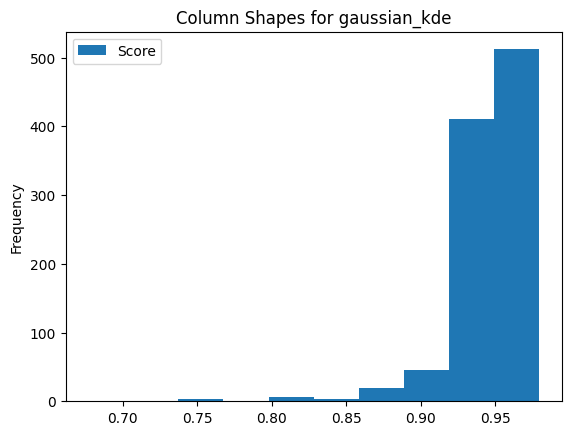

norm:           Column        Metric     Score
0     cg00000029  KSComplement  0.911524
1     cg00000108  KSComplement  0.855707
2     cg00000109  KSComplement  0.923098
3     cg00000165  KSComplement  0.877341
4     cg00000236  KSComplement  0.909915
...          ...           ...       ...
996   cg00041270  KSComplement  0.960220
997   cg00041311  KSComplement  0.886817
998   cg00041328  KSComplement  0.950463
999   cg00041368  KSComplement  0.927049
1000         age  KSComplement  0.939598

[1001 rows x 3 columns]


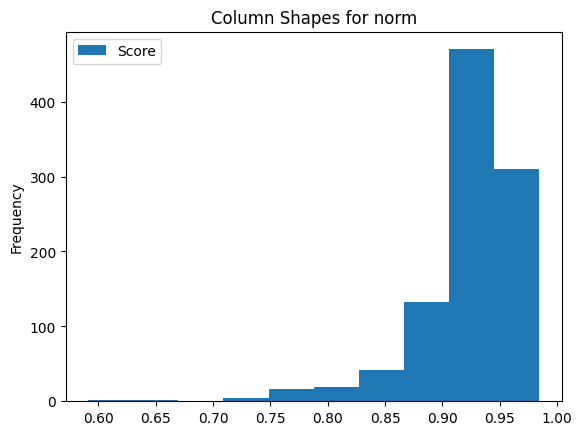

beta:           Column        Metric     Score
0     cg00000029  KSComplement  0.915207
1     cg00000108  KSComplement  0.932573
2     cg00000109  KSComplement  0.938720
3     cg00000165  KSComplement  0.912634
4     cg00000236  KSComplement  0.933159
...          ...           ...       ...
996   cg00041270  KSComplement  0.942244
997   cg00041311  KSComplement  0.924476
998   cg00041328  KSComplement  0.933268
999   cg00041368  KSComplement  0.963659
1000         age  KSComplement  0.957232

[1001 rows x 3 columns]


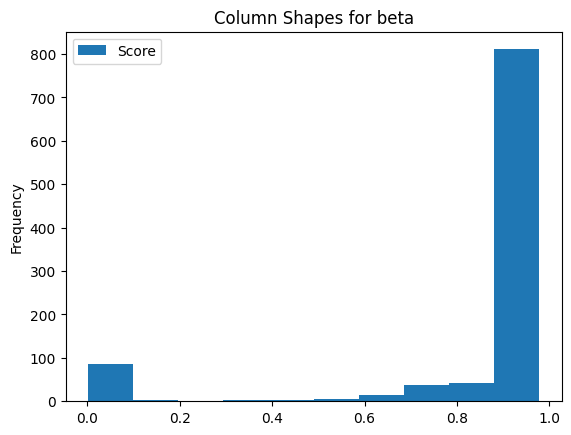

truncnorm:           Column        Metric     Score
0     cg00000029  KSComplement  0.958134
1     cg00000108  KSComplement  0.891085
2     cg00000109  KSComplement  0.935366
3     cg00000165  KSComplement  0.893012
4     cg00000236  KSComplement  0.954390
...          ...           ...       ...
996   cg00041270  KSComplement  0.952500
997   cg00041311  KSComplement  0.887463
998   cg00041328  KSComplement  0.761037
999   cg00041368  KSComplement  0.897537
1000         age  KSComplement  0.957598

[1001 rows x 3 columns]


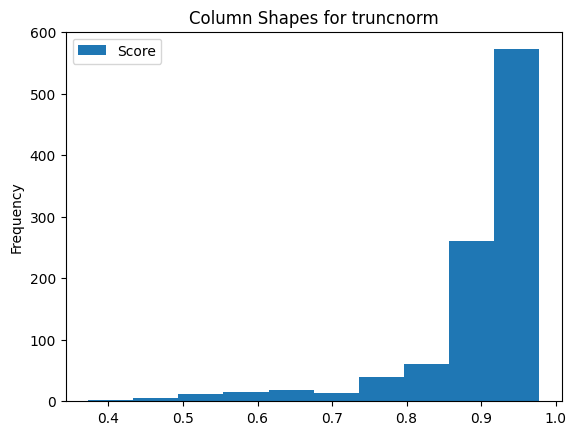

gamma:           Column        Metric     Score
0     cg00000029  KSComplement  0.946573
1     cg00000108  KSComplement  0.421524
2     cg00000109  KSComplement  0.852268
3     cg00000165  KSComplement  0.904768
4     cg00000236  KSComplement  0.931598
...          ...           ...       ...
996   cg00041270  KSComplement  0.496098
997   cg00041311  KSComplement  0.328110
998   cg00041328  KSComplement  0.937585
999   cg00041368  KSComplement  0.937451
1000         age  KSComplement  0.953829

[1001 rows x 3 columns]


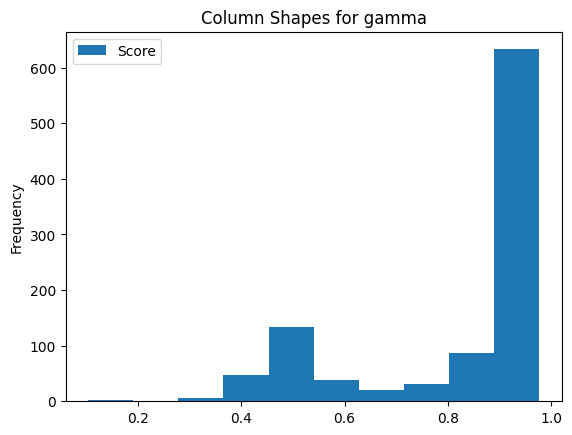

In [ ]:
shapes_report = {kind: report.get_details('Column Shapes') for kind, report in quality_report.items()}
for kind, report in quality_report.items():
    print(f"{kind}: {report.get_details('Column Shapes')}")
    report.get_details('Column Shapes').plot.hist()
    plt.title(f'Column Shapes for {kind}')
    plt.show()

And we can verify this using the visualization functions.

In [ ]:
fig = get_column_plot(
    real_data=hannum_data,
    synthetic_data=synthetic_data_customized,
    column_name='room_rate',
    metadata=hannum_metadata
)

fig.show()

# 4. Conditional Sampling
Another benefit of using the Gaussian Copula is the ability to **efficiently sample conditions**. This allows us to simulate hypothetical scenarios.

Let's start by creating a scenario where every hotel guest is staying in a `SUITE` (half with rewards and half without).

In [ ]:
from sdv.sampling import Condition

suite_guests_with_rewards = Condition(
    num_rows=250,
    column_values={'room_type': 'SUITE', 'has_rewards': True}
)

suite_guests_without_rewards = Condition(
    num_rows=250,
    column_values={'room_type': 'SUITE', 'has_rewards': False}
)

In [ ]:
fig = get_column_plot(
    real_data=real_data,
    synthetic_data=simulated_synthetic_data,
    column_name='room_type',
    metadata=metadata
)

fig.update_layout(
    title='Using synthetic data to simulate room_type scenario'
)

fig.show()